In [0]:
%run ../../shared

Found workspace bupa_demo at location australiaeast

In [0]:
username = get_username()
notebook_path = get_notebook_path()
folder_path = get_folder_path()

print('username: "{}"'.format(username))
print('notebook_path: "{}"'.format(notebook_path))
print('folder_path: "{}"'.format(folder_path))

username: "siddhanth.chaurasiya@bupa.com.au"
notebook_path: "/Shared/Bupa Workshop/Day 1/2. Building ML Models/1.0 Machine Learning"
folder_path: "/Shared/Bupa Workshop/Day 1/2. Building ML Models"

#0. Setup
First, let's prepare our environment:
- Create an MLFlow Experiment
- Load our data
- Separate it into test & train

In [0]:
import mlflow
import mlflow.pyfunc
from mlflow.utils.file_utils import TempDir

from sklearn.model_selection import train_test_split

import copy
import os
import json

Let's create an experiment to log runs there. `Experiment` contains multiple Machine Learning `runs` to help us organise our work.

![](https://databricks.com/wp-content/uploads/2019/10/model-registry-new.png)

Here is what we need to do:
- Run cell below 
- It will create a Machine Learning Experiment that will be located in `/{username}/Bupa Workshop/cross-selling-insurance`
- Alternatively, click link the cell created.
- Observe empty Experiment. We will be pushing Machine Learning models to it soon!

In [0]:
experiment_location = os.path.join('/', *folder_path.split('/')[:-2], 'cross-selling-insurance')

try:
  experiment_id = mlflow.create_experiment(experiment_location)
except Exception as e:
  experiment_id = mlflow.get_experiment_by_name(experiment_location).experiment_id
  
print(f'Experiment ID: "{experiment_id}"')
print(f'Experiment Location: "{experiment_location}"')

displayHTML(f"<h4>Check out the experiment at <a href='/#mlflow/experiments/{experiment_id}'>/#mlflow/experiments/{experiment_id}</a></h4>")

Check out the experiment at /#mlflow/experiments/3952948960390541

In [0]:
# we are using Azure Machine Learning Dataset: a unified interface to access your data for Machine Learning
# this will be important later on, where we use same dataset for visual ML
dataset = Dataset.get_by_name(ws, name='car_and_health_insurance_cross_sell')
df = dataset.to_pandas_dataframe()
display(df)

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Claims_Amount,Claims_Num
1,Male,47,1,28.0,0,> 2 Years,Yes,2753.0181741645374,26.0,217,1,311,17
2,Male,79,1,3.0,0,1-2 Year,No,2282.227158965292,26.0,183,0,48,2
3,Male,50,1,28.0,0,> 2 Years,Yes,2606.0235813876698,26.0,27,1,507,33
4,Male,24,1,11.0,1,< 1 Year,No,1947.6103012412837,152.0,203,0,0,0
5,Female,32,1,41.0,1,< 1 Year,No,1871.1867236077549,152.0,39,0,435,9
6,Female,27,1,33.0,0,< 1 Year,Yes,178.97952731627856,160.0,176,0,0,0
7,Male,26,1,11.0,0,< 1 Year,Yes,1590.1956710264187,152.0,249,0,0,0
8,Female,59,1,28.0,0,1-2 Year,Yes,2179.807315386965,26.0,72,1,1224,32
9,Female,27,1,3.0,1,< 1 Year,No,1879.557249029771,152.0,28,0,180,7
10,Female,35,1,6.0,1,< 1 Year,No,1957.9543651774336,152.0,80,0,102,3


In [0]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=65)

print('Dataset sizes:')
print(f'\t->df_train size={df_train.shape[0]}')
print(f'\t->df_test size={df_test.shape[0]}')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-558668845590092> in <module> 
 ----> 1 df_train , df_test = train_test_split ( df , test_size = 0.2 , random_state = 65 ) 
 2 
 3 print ( 'Dataset sizes:' ) 
 4 print ( f'\t->df_train size={df_train.shape[0]}' ) 
 5 print ( f'\t->df_test size={df_test.shape[0]}' ) 

 NameError : name 'df' is not defined

#1. Quick EDA

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import pandas as pd

Looks like the most useful features to predict `Response` are:
- `Age`
- `Previously_Insured`
- `Policy_Sales_Channel`
- `Claimns_Amount`
- `Claims_Num`

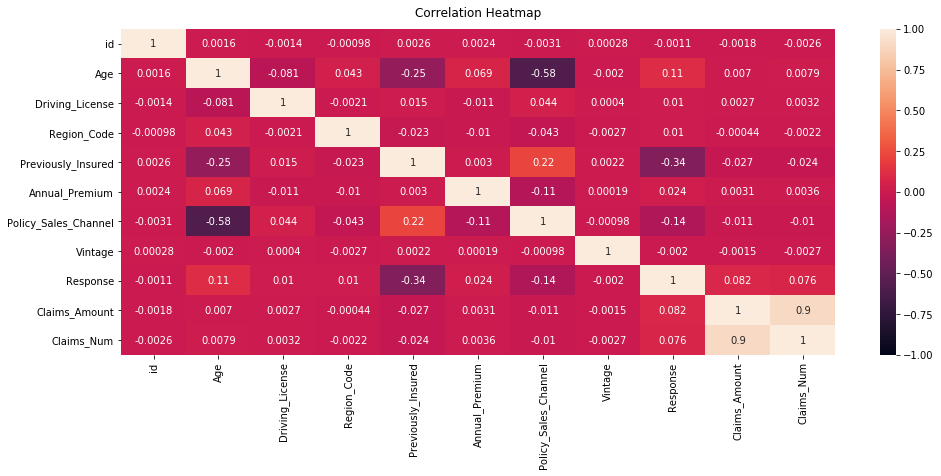

In [0]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

It looks like we are dealing with imbalanced dataset. `1` has 46.7k samples vs `0` 334.4k

In [0]:
display(df.groupby('Response').count()[['id']])

id
334399
46710


In [0]:
response_1 = df_train[df_train['Response'] == 1]
response_0 = df_train[df_train['Response'] == 0]

df_train_balanced = pd.concat([response_1, response_0.sample(response_1.shape[0])])

In [0]:
correlated_features = ['Age', 'Previously_Insured', 'Policy_Sales_Channel', 'Claims_Amount', 'Claims_Num']
dbutils.widgets.dropdown('correlated_features', correlated_features[0], correlated_features)

In [0]:
fig = px.histogram(df_train_balanced.sample(10000), x=dbutils.widgets.get('correlated_features'), marginal='box', color='Response')
fig.show()

# 2. Baseline Model
We will now create a Baseline Machine Learning model. 
Baseline model is there to show us how good (or bad) performance is on something relatively simple. The task is to beat this benchmark with more advanced models.

We will be using `pyfunc` flavour to log models to MLFlow. This is a special type of MLFlow 'flavour' that can handle anything! You can build custom models with custom serialisation / deserialisation methods in there. There are many flavours: `sklearn`, `tensorflow`, `keras`, among others. `pyfunc` is on a advanced side: if you can use it, you can use anything else. Here is how it will look on MLFlow UI:

![](https://bupademoflatfile.blob.core.windows.net/public/mlflow-model.png)

In [0]:
import cloudpickle as pickle
from sklearn.metrics import f1_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

###2.1 Defining model structure

In [0]:
class BaselineModel(mlflow.pyfunc.PythonModel):
  def __init__(self, random_forest_params={}, feature_columns=None):
    self._random_forest_params = random_forest_params
    self._feature_columns = feature_columns
  
  def fit(self, X, y):
    _X = copy.deepcopy(X)
    _X = _X[self._feature_columns]
    self._scaler = MinMaxScaler().fit(_X)
    _X = self._scaler.transform(_X)
    
    self._rf = RandomForestClassifier(**self._random_forest_params)
    self._rf.fit(_X, y)
    return self
      
  def predict(self, context, X):
    _y = self._predict(X)
    return _y 
    
  def _predict(self, X):
    _X = copy.deepcopy(X)
    _X = _X[self._feature_columns]
    _X = self._scaler.transform(_X)
    _y = self._rf.predict(_X)
    return _y
    
  def load_context(self, context):
    # this is where we define how to load "components" of the model
    with open(context.artifacts['feature_cols'], 'rb') as f:
      self._feature_columns = json.load(f)
      
    with open(context.artifacts['scaler'], 'rb') as f:
      self._scaler = pickle.load(f)
    
    with open(context.artifacts['random_forest'], 'rb') as f:
      self._rf = pickle.load(f)
      
  def log_to_mlflow(self):
    # this is the actual logging method: we define how to save "components" of the model
    with TempDir() as local_artifacts_dir:
      # dumping column names
      feature_cols_path = local_artifacts_dir.path('columns.json')
      with open(feature_cols_path, 'w') as m:
        json.dump(self._feature_columns, m)
      
      # dumping scaler
      scaler_path = local_artifacts_dir.path('scaler.pkl')
      with open(scaler_path, 'wb') as m:
        pickle.dump(self._scaler, m)
      
      # dumping model
      model_path = local_artifacts_dir.path('model.pkl')
      with open(model_path, 'wb') as m:
        pickle.dump(self._rf, m)
           
      # all of the model subcomponents will need to go here
      artifacts = {
        'feature_cols': feature_cols_path, 'scaler': scaler_path, 'random_forest': model_path
      }
      
      mlflow.pyfunc.log_model(
        artifact_path='model', python_model=self, artifacts=artifacts
      )

###2.2 Logging model run to MLFlow

MLFlow tracking server exists to help Data Scientist make better decisions. It contains all of the runs (typically hundreds to thousands) per experiment, and help you compare and contrast your models. Once you have hundreds of runs in your experiment, it will look something like this: 

![](https://bupademoflatfile.blob.core.windows.net/public/parallel-coordinates.gif)

In [0]:
features = ['Age', 'Previously_Insured', 'Policy_Sales_Channel', 'Claims_Amount', 'Claims_Num']
label = 'Response'

X_train = df_train
y_train = df_train[label]

X_test = df_test
y_test = df_test[label]

with mlflow.start_run(experiment_id=experiment_id, run_name='baseline'):
  params = {'n_estimators': 200, 'max_depth': 7}
  print('Started run with params={}'.format(params))

  print('\ttraining on {} samples'.format(X_train.shape[0]))   
  model = BaselineModel(params, features).fit(X_train, y_train)
  print('\tdone training')
  
  print('\ttesting on {} samples'.format(X_test.shape[0]))
  y_pred_train = model._predict(X_train)
  y_pred_test = model._predict(X_test)
  print('\tdone inference')
  
  params = model._rf.get_params()
  mlflow.log_params(params)
  
  f1_train = f1_score(y_train, y_pred_train)
  print(f'\t-> f1_train={f1_train}')
  mlflow.log_metric('f1_train', f1_train)
  
  f1_test = f1_score(y_test, y_pred_test)
  print(f'\t-> f1_test={f1_test}')
  mlflow.log_metric('f1_test', f1_test)
  
  model.log_to_mlflow()

Started run with params={'n_estimators': 200, 'max_depth': 7}
	training on 304887 samples
	done training
	testing on 76222 samples
	done inference
	-> f1_train=0.06700065786144425
	-> f1_test=0.06415817613235146

# 3. (Hopefully) better models
Our baseline model is pretty bad. Let's see if we can create a better one by adding new features & changing algorithms.

In [0]:
display(df_train)

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Claims_Amount,Claims_Num,x_Gender,x_Vehicle_Age,x_Vehicle_Damage
359893,Male,35,1,35.0,1,< 1 Year,No,2749.819680710596,152.0,222,0,39,2,0,0,0
354862,Male,61,1,28.0,0,> 2 Years,Yes,1628.2373272126542,26.0,277,0,209,4,0,2,1
181208,Male,61,1,28.0,0,1-2 Year,Yes,4167.024493015349,26.0,168,1,5873,159,0,1,1
348839,Female,27,1,35.0,0,< 1 Year,Yes,2286.1742359935597,152.0,147,0,70,1,1,0,1
122025,Female,42,1,33.0,0,1-2 Year,Yes,178.97952731627856,156.0,265,0,113,3,1,1,1
336035,Female,30,1,36.0,0,1-2 Year,Yes,1841.3114336869007,124.0,294,0,231,9,1,1,1
9180,Male,66,1,28.0,0,1-2 Year,No,4212.620037997063,26.0,160,0,13,1,0,1,0
374258,Female,28,1,30.0,1,< 1 Year,No,2484.6849892945424,152.0,91,0,344,25,1,0,0
19173,Male,23,1,46.0,0,< 1 Year,Yes,2047.1038635745153,160.0,219,0,71,3,0,0,1
267117,Female,46,1,28.0,1,1-2 Year,No,1823.685693164119,29.0,294,0,149,3,1,1,0


In [0]:
def gender_encoder(df, use_prefix=False):
  _mapping = {'Male': 0, 'Female': 1}
  
  new_col = 'Gender'
  if use_prefix:
    new_col = 'x_Gender' 
    
  df[new_col] = df['Gender'].apply(lambda x: _mapping[x])
  return df
  
  
def vehicle_age_encoder(df, use_prefix=False):
  _mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
  
  new_col = 'Vehicle_Age'
  if use_prefix:
    new_col = 'x_Vehicle_Age' 
    
  df[new_col] = df['Vehicle_Age'].apply(lambda x: _mapping[x])
  return df
  
  
def vehicle_damage_encoder(df, use_prefix=False):
  _mapping = {'No': 0, 'Yes': 1}
  
  new_col = 'Vehicle_Damage'
  if use_prefix:
    new_col = 'x_Vehicle_Damage' 
    
  df[new_col] = df['Vehicle_Damage'].apply(lambda x: _mapping[x])
  return df


funcs = [
  gender_encoder,
  vehicle_age_encoder,
  vehicle_damage_encoder,
]

for f in funcs:
  df_train = f(df_train, True)
  df_test = f(df_test, True)

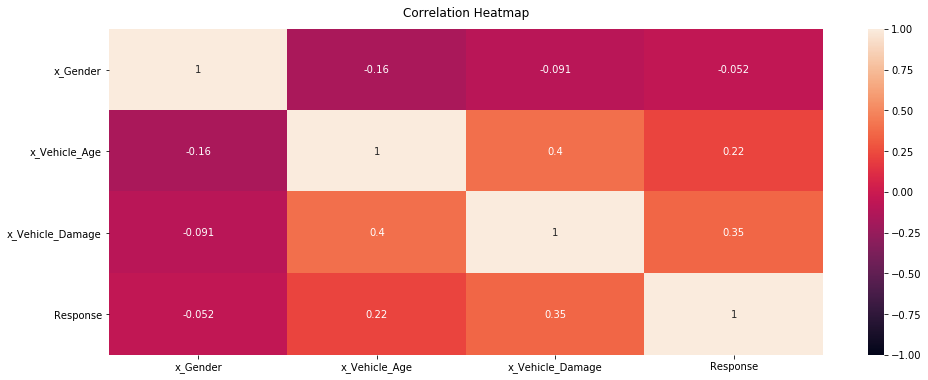

In [0]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train[[c for c in df_train.columns if c.startswith('x')] + ['Response']].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### 3.1 Getting new features out

In [0]:
features = [
  'Age', 
  'Previously_Insured',
  'Policy_Sales_Channel',
  'Claims_Amount',
  'Claims_Num',
  'Driving_License',
  'Region_Code',
  'Annual_Premium',
  'Vintage',
  'x_Gender',
  'x_Vehicle_Age',
  'x_Vehicle_Damage'
]

label = 'Response'

X_train = df_train[features]
y_train = df_train[label]

X_test = df_test[features]
y_test = df_test[label]

#### 3.2 Let's try XGboost
![](https://machinelearningapplied.com/wp-content/uploads/2019/10/xgboost_logo.png)

XGBoost is a powerful algorithm that works very well out of the box. It is the closest thing to silver bullet in Machine Learning right now for any tabular datasets.

In [0]:
import xgboost as xgb

In [0]:
# Looks promising, let's keep experimenting

params = {
  'max_depth': 2, 'reg_alpha': 0.01, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.18935016445906305

In [0]:
params = {
  'max_depth': 3, 'reg_alpha': 0.01, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.2116604396559215

In [0]:
params = {
  'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.01
}

xgb_model = xgb.XGBClassifier(**params).fit(X=X_train, y=y_train)
y_pred = xgb_model.predict(X_test)

f1_test = f1_score(y_test, y_pred)
print(f1_test)

0.219476868024197

#4. Hyper-parameter Search

Use HyperOpt with Spark trials to run distributed hyperparameters tuning across workers in parallel

![my_test_image](https://www.jeremyjordan.me/content/images/2017/11/grid_search.gif)
![my_test_image](https://www.jeremyjordan.me/content/images/2017/11/Bayesian_optimization.gif)

In [0]:
import copy
import cloudpickle as pickle

  
class XGBoostModel(mlflow.pyfunc.PythonModel):
  def __init__(self, xgb_params={}, feature_columns=None):
    self._xgb_params = xgb_params
    self._feature_columns = feature_columns
    
    self._transformations = [
      gender_encoder,
      vehicle_age_encoder,
      vehicle_damage_encoder
    ]
  
  def fit(self, X, y):
    _X = copy.deepcopy(X)
    for f in self._transformations:
      _X = f(_X)
      
    _X = _X[self._feature_columns]
    
    self._model = xgb.XGBClassifier(**self._xgb_params).fit(X=_X, y=y)
    return self
      
  def predict(self, context, X):
    _y = self._predict(X)
    return _y 
    
  def _predict(self, X):
    _X = copy.deepcopy(X)
    for f in self._transformations:
      _X = f(_X)
      
    _X = _X[self._feature_columns]
    
    _y = self._model.predict(_X)
    return _y
    
  def load_context(self, context):
    with open(context.artifacts['feature_cols'], 'rb') as f:
      self._feature_columns = json.load(f)
      
    with open(context.artifacts['transformations'], 'rb') as f:
      self._transformations = pickle.load(f)
    
    with open(context.artifacts['xgb'], 'rb') as f:
      self._model = pickle.load(f)
      
  def log_to_mlflow(self):
    with TempDir() as local_artifacts_dir:
      # dumping column names
      feature_cols_path = local_artifacts_dir.path('columns.json')
      with open(feature_cols_path, 'w') as m:
        json.dump(self._feature_columns, m)
      
      # dumping scaler
      transformations_path = local_artifacts_dir.path('transformations.pkl')
      with open(transformations_path, 'wb') as m:
        pickle.dump(self._transformations, m)
      
      # dumping model
      model_path = local_artifacts_dir.path('model.pkl')
      with open(model_path, 'wb') as m:
        pickle.dump(self._model, m)
           
      # all of the model subcomponents will need to go here
      artifacts = {
        'feature_cols': feature_cols_path, 'transformations': transformations_path, 'xgb': model_path
      }
      
      mlflow.pyfunc.log_model(
        artifact_path='model', python_model=self, artifacts=artifacts
      )

In [0]:
features = [
  'Age', 
  'Previously_Insured',
  'Policy_Sales_Channel',
  'Claims_Amount',
  'Claims_Num',
  'Driving_License',
  'Region_Code',
  'Annual_Premium',
  'Vintage',
  'Gender',
  'Vehicle_Age',
  'Vehicle_Damage'
]

In [0]:
X_train = df_train
y_train = df_train[label]

X_test = df_test
y_test = df_test[label]

In [0]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

fspace = {
    'max_depth': scope.int(hp.quniform('max_depth', 2, 11, q=1)),
    'reg_alpha': hp.uniform('reg_alpha', 0.001, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 0.001, 0.1), 
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 250, q=1))
}

def f(params):
  with mlflow.start_run(experiment_id=experiment_id, run_name='HyperOpt-XGBoost'):
    model = XGBoostModel(xgb_params=params, feature_columns=features).fit(X_train, y_train)
    model.log_to_mlflow()
    
    y_pred_test = model._predict(X_test)
    y_pred_train = model._predict(X_train)
    
    f1_test = f1_score(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train)
    mlflow.log_metrics({'f1_train': f1_train, 'f1_test': f1_test})
    mlflow.log_params(model._model.get_params())
    
    return {'loss': -f1_test, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=10, trials=trials)

0%| | 0/10 [00:00<?, ?trial/s, best loss=?] 10%|█ | 1/10 [00:18<02:42, 18.10s/trial, best loss: -0.22408198121263875] 20%|██ | 2/10 [00:38<02:29, 18.70s/trial, best loss: -0.24393389762192666] 30%|███ | 3/10 [01:28<03:16, 28.03s/trial, best loss: -0.27794561933534745] 40%|████ | 4/10 [02:07<03:09, 31.52s/trial, best loss: -0.27794561933534745] 50%|█████ | 5/10 [02:42<02:42, 32.53s/trial, best loss: -0.27794561933534745] 60%|██████ | 6/10 [03:08<02:02, 30.63s/trial, best loss: -0.27794561933534745] 70%|███████ | 7/10 [03:46<01:38, 32.81s/trial, best loss: -0.27794561933534745] 80%|████████ | 8/10 [04:14<01:02, 31.43s/trial, best loss: -0.27794561933534745] 90%|█████████ | 9/10 [04:31<00:27, 27.07s/trial, best loss: -0.27794561933534745]100%|██████████| 10/10 [05:10<00:00, 30.53s/trial, best loss: -0.28352716031208597]100%|██████████| 10/10 [05:10<00:00, 31.03s/trial, best loss: -0.28352716031208597]

In [0]:
displayHTML(f"<h4>Now go back to <a href='/#mlflow/experiments/{experiment_id}'>/#mlflow/experiments/{experiment_id}</a> and check out your best model.</h4>")

Now go back to /#mlflow/experiments/3952948960390541 and check out your best model.